<a href="https://colab.research.google.com/github/badhan7700/Breast-Cancer-Diagnosis-Prediction-ML/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Diagnosis Prediction with KNN & K-Means
This notebook walks through:
1. Data loading and preprocessing
2. K-Means clustering (k=2) and comparison to labels
3. KNN classifier with hyperparameter tuning (GridSearchCV)
4. Evaluation: accuracy, precision, recall, F1, confusion matrix, ROC AUC
5. PCA visualizations, learning curve, saving the final model
Copy each "CELL" block into a new notebook cell in the same order.


## CELL 1: Imports and constants

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve,
                             adjusted_rand_score)
from sklearn.decomposition import PCA
import joblib

# Constants
DATA_PATH = "/content/Dataset.csv"   # change to your file path if needed
RANDOM_STATE = 42

## CELL 2: Load dataset & quick inspection

In [ ]:
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Upload or change DATA_PATH."
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nDiagnosis value counts (original):\n", df['diagnosis'].value_counts())

Shape: (569, 33)
Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Diagnosis value counts (original):
 diagnosis
B    357
M    212
Name: count, dtype: int64


## CELL 3: Drop unwanted cols and encode target


In [ ]:
# Drop id and unnamed if present
drop_cols = [c for c in ['id', 'Unnamed: 32'] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print("Dropped:", drop_cols)

# Encode diagnosis: M -> 1, B -> 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
print("Encoded diagnosis counts:\n", df['diagnosis'].value_counts())

Dropped: ['id', 'Unnamed: 32']
Encoded diagnosis counts:
 diagnosis
0    357
1    212
Name: count, dtype: int64


## CELL 4: Features, scaling, and train-test split (80/20 stratified)

In [ ]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
feature_names = X.columns.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train/test shapes:", X_train.shape, X_test.shape)

Train/test shapes: (455, 30) (114, 30)


## CELL 5: K-Means clustering (k=2) and comparison to true labels

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_scaled)

print("Crosstab (Actual vs Cluster):")
print(pd.crosstab(y, clusters))

ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index: {ari:.4f}")

Crosstab (Actual vs Cluster):
col_0        0    1
diagnosis          
0            9  348
1          180   32
Adjusted Rand Index: 0.7302


## CELL 6: Baseline KNN (k=5) evaluation

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Baseline KNN (k=5) metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Baseline KNN (k=5) metrics:
Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1: 0.95


## CELL 7: Tune KNN with Pipeline + GridSearchCV

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV F1: 0.972768326201162


## CELL 8: Final evaluation (confusion matrix, classification report, ROC AUC)

Test set metrics (tuned KNN):
Accuracy: 0.9736842105263158
Precision: 1.0
Recall: 0.9285714285714286
F1: 0.9629629629629629

Classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[72  0]
 [ 3 39]]
ROC AUC: 0.9737103174603174


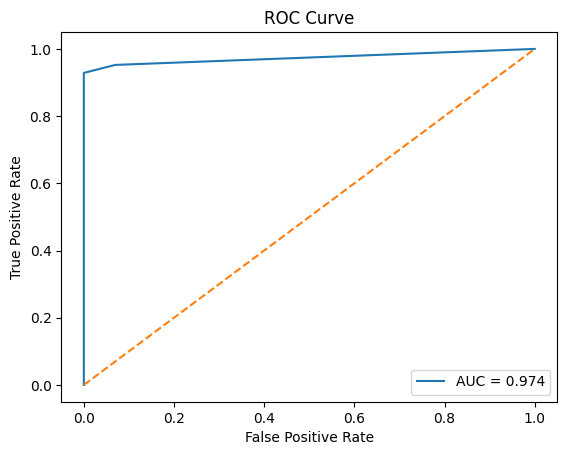

In [ ]:
y_pred_best = best_model.predict(X_test)
print("Test set metrics (tuned KNN):")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("\nClassification report:\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", cm)

# ROC AUC (KNN supports predict_proba)
if hasattr(best_model.named_steps['knn'], "predict_proba"):
    probs = best_model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probs)
    print("ROC AUC:", auc)
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve'); plt.legend(); plt.show()
else:
    print("predict_proba not available.")

## CELL 9: PCA 2D visualization (true labels vs tuned predictions)



Explained variance ratios (PC1, PC2): [0.53097689 0.1728349 ]


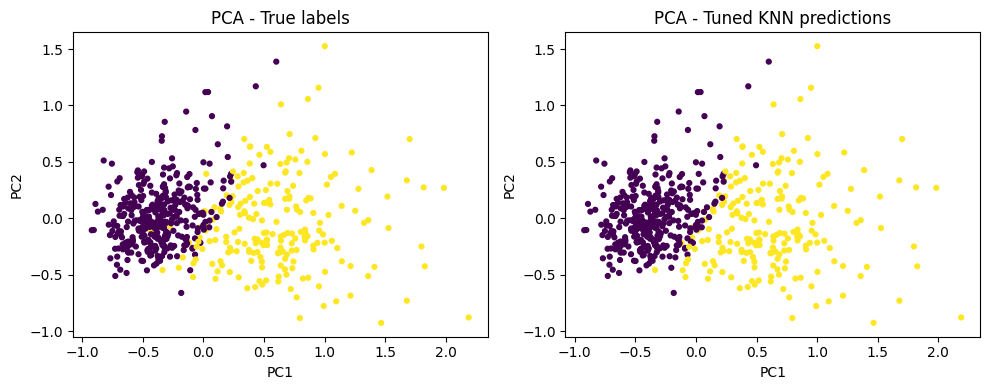

In [ ]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratios (PC1, PC2):", pca.explained_variance_ratio_)

preds_full = best_model.predict(X_scaled)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=12)
plt.title('PCA - True labels')
plt.xlabel('PC1'); plt.ylabel('PC2')

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=preds_full, s=12)
plt.title('PCA - Tuned KNN predictions')
plt.xlabel('PC1'); plt.ylabel('PC2')

plt.tight_layout(); plt.show()


## CELL 10: Save final model and scaler; summary print

In [ ]:
joblib.dump(best_model, "knn_tuned_pipeline.joblib")
joblib.dump(scaler, "minmax_scaler.joblib")
print("Saved: knn_tuned_pipeline.joblib and minmax_scaler.joblib")

print("\nSUMMARY:")
print("- Dataset shape:", df.shape)
print("- Number of features:", len(feature_names))
print("- KMeans ARI:", f"{ari:.4f}")
print("- Best KNN params:", grid.best_params_)
print("- Test F1 (tuned):", f1_score(y_test, y_pred_best))

Saved: knn_tuned_pipeline.joblib and minmax_scaler.joblib

SUMMARY:
- Dataset shape: (569, 31)
- Number of features: 30
- KMeans ARI: 0.7302
- Best KNN params: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
- Test F1 (tuned): 0.9629629629629629
